<br/>

#### Connected to Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


<br/>

#### Importing Necessary Modules

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px

<br/>

#### Load the dataset

In [5]:
df = pd.read_csv('drive/My Drive/Datasets/nyc_taxi.csv',
                 parse_dates = ['timestamp'], index_col = 'timestamp')

<br/>

#### Reconnaissance

In [6]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [7]:
df.tail()

,value
timestamp,
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309
2015-01-31 23:00:00,26591
2015-01-31 23:30:00,26288


In [8]:
df.shape

(10320, 1)

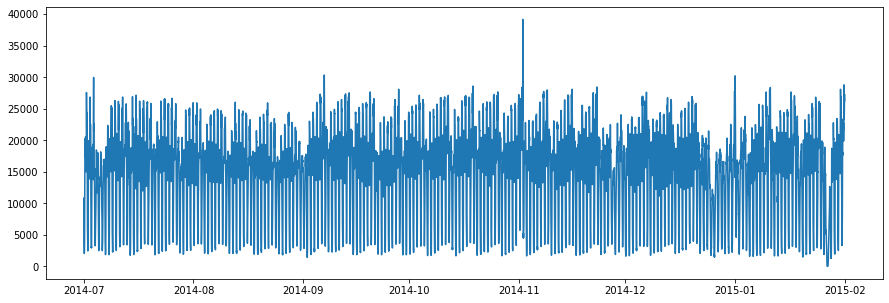

In [9]:
plt.figure(figsize=(15, 5))

plt.plot(df['value'])
plt.show()

<br/>

#### Resampling to **Hour**

In [10]:
df_H = df.resample('H').mean()
df_H.shape

(5160, 1)

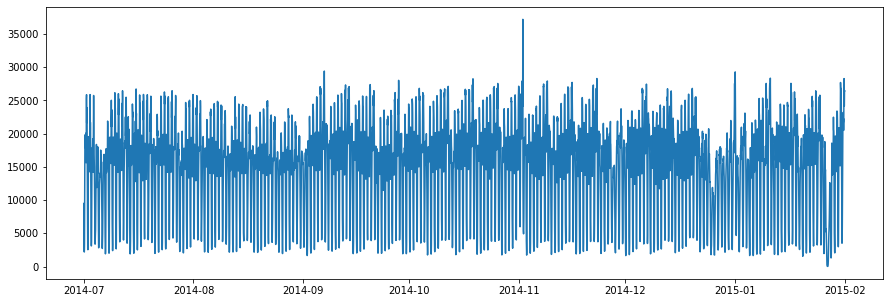

In [11]:
plt.figure(figsize=(15, 5))

plt.plot(df_H['value'])
plt.show()

<br/>

## Anomaly Detection by Facebook Prophet

In [12]:
# importing necessary modules

from fbprophet import Prophet

In [13]:
# renaming the column according to the requirement of Prophet

df_taxi = df_H.reset_index()[['timestamp', 'value']].rename({'timestamp' : 'ds', 'value' : 'y'}, axis = 'columns')

In [14]:
# splitting into train and test set

train = df_taxi[(df_taxi['ds'] >= '2014-07-01') & (df_taxi['ds'] <= '2015-01-27')]
test = df_taxi[(df_taxi['ds'] > '2015-01-27')]

In [15]:
# shape of the train and test set

print('Shape of train set {}'.format(train.shape))
print('\nShape of test set {}'.format(test.shape))

Shape of train set (5041, 2)

Shape of test set (119, 2)


In [16]:
# train the model

model = Prophet(changepoint_range= 0.95)
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [17]:
# Creating future dataframe for predicting

future = model.make_future_dataframe(periods = 119, freq = 'H')

In [18]:
future.head()

,ds
0,2014-07-01 00:00:00
1,2014-07-01 01:00:00
2,2014-07-01 02:00:00
3,2014-07-01 03:00:00
4,2014-07-01 04:00:00


In [19]:
future.tail()

,ds
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00
5159,2015-01-31 23:00:00


In [20]:
# Prediction

forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2014-07-01 00:00:00,13240.732792,8648.919018,17961.769363
1,2014-07-01 01:00:00,10232.486172,5265.294384,15409.450001
2,2014-07-01 02:00:00,6669.099458,1887.495497,11751.387801
3,2014-07-01 03:00:00,3448.054270,-1339.556548,8400.847768
4,2014-07-01 04:00:00,2017.409931,-2422.171190,6572.605422


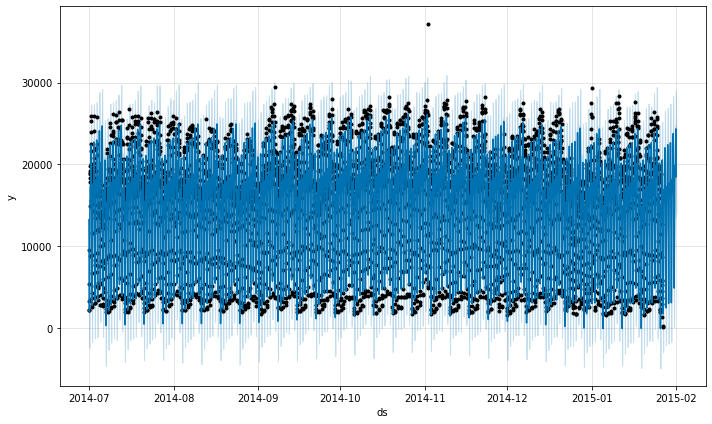

In [21]:
# Plotting

model.plot(forecast)
plt.show()

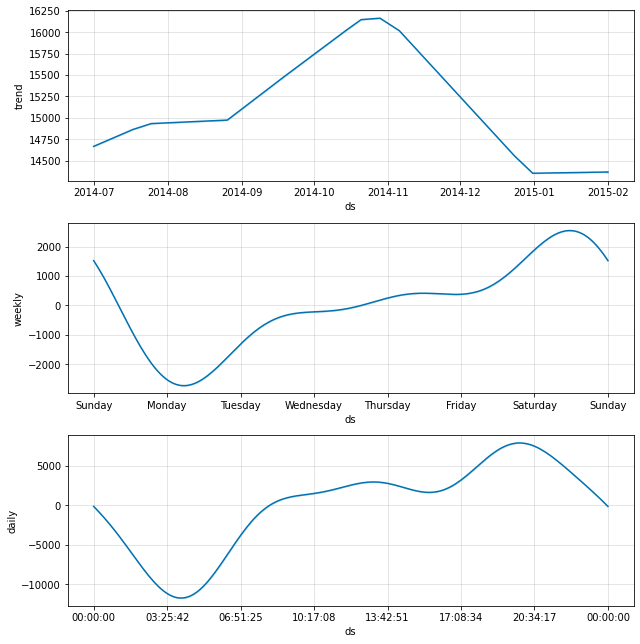

In [22]:
# Plotting the model components

model.plot_components(forecast)
plt.show()

In [23]:
# Concatenate the prediction with actual values

result = pd.concat([df_taxi.set_index('ds')['y'], forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]], axis = 1)

In [24]:
result.head()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8648.919018,17961.769363
2014-07-01 01:00:00,5433.0,10232.486172,5265.294384,15409.450001
2014-07-01 02:00:00,3346.5,6669.099458,1887.495497,11751.387801
2014-07-01 03:00:00,2216.5,3448.054270,-1339.556548,8400.847768
2014-07-01 04:00:00,2189.5,2017.409931,-2422.171190,6572.605422


In [25]:
# Errors

result['error'] = result['y'] - result['yhat']
result.head()

,y,yhat,yhat_lower,yhat_upper,error
ds,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8648.919018,17961.769363,-3755.232792
2014-07-01 01:00:00,5433.0,10232.486172,5265.294384,15409.450001,-4799.486172
2014-07-01 02:00:00,3346.5,6669.099458,1887.495497,11751.387801,-3322.599458
2014-07-01 03:00:00,2216.5,3448.054270,-1339.556548,8400.847768,-1231.554270
2014-07-01 04:00:00,2189.5,2017.409931,-2422.171190,6572.605422,172.090069


In [26]:
# Uncertainity

result['uncertainity'] = result['yhat_upper'] - result['yhat_lower']
result.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainity
ds,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8648.919018,17961.769363,-3755.232792,9312.850344
2014-07-01 01:00:00,5433.0,10232.486172,5265.294384,15409.450001,-4799.486172,10144.155617
2014-07-01 02:00:00,3346.5,6669.099458,1887.495497,11751.387801,-3322.599458,9863.892304
2014-07-01 03:00:00,2216.5,3448.054270,-1339.556548,8400.847768,-1231.554270,9740.404316
2014-07-01 04:00:00,2189.5,2017.409931,-2422.171190,6572.605422,172.090069,8994.776612


In [27]:
# Condition of anomaly (Here 1.5 was chosen by us)

result[result['error'].abs() > 1.5*result['uncertainity']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainity
ds,,,,,,
2014-11-02 01:00:00,37204.5,14218.892870,9427.329865,18903.963740,22985.607130,9476.633875
2015-01-01 01:00:00,29292.0,11405.545567,6368.572842,16326.914571,17886.454433,9958.341729
2015-01-01 02:00:00,25753.5,7770.054639,3256.403074,12791.440015,17983.445361,9535.036941
2015-01-01 03:00:00,22067.0,4478.895177,-176.036095,9482.462150,17588.104823,9658.498245
2015-01-26 19:00:00,4565.5,19771.308307,15173.670725,24582.014635,-15205.808307,9408.343910
2015-01-26 20:00:00,3630.5,20546.581743,15833.857387,25176.201339,-16916.081743,9342.343952
2015-01-26 21:00:00,2907.0,19647.710004,14592.908938,24024.685941,-16740.710004,9431.777003
2015-01-26 22:00:00,1324.5,17691.969234,12940.245812,22395.211505,-16367.469234,9454.965693
2015-01-26 23:00:00,243.0,15411.348672,10641.816416,20001.741161,-15168.348672,9359.924745


In [29]:
# Anomaly Detection

result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) >  1.5*x['uncertainity']) else 'No', axis=1)
result

,y,yhat,yhat_lower,yhat_upper,error,uncertainity,anomaly
ds,,,,,,,
2014-07-01 00:00:00,9485.5,13240.732792,8648.919018,17961.769363,-3755.232792,9312.850344,No
2014-07-01 01:00:00,5433.0,10232.486172,5265.294384,15409.450001,-4799.486172,10144.155617,No
2014-07-01 02:00:00,3346.5,6669.099458,1887.495497,11751.387801,-3322.599458,9863.892304,No
2014-07-01 03:00:00,2216.5,3448.054270,-1339.556548,8400.847768,-1231.554270,9740.404316,No
2014-07-01 04:00:00,2189.5,2017.409931,-2422.171190,6572.605422,172.090069,8994.776612,No
...,...,...,...,...,...,...,...
2015-01-31 19:00:00,28288.5,23778.529213,18679.545164,28404.803494,4509.970787,9725.258330,No
2015-01-31 20:00:00,24138.0,24342.584334,19683.288298,29061.752374,-204.584334,9378.464076,No
2015-01-31 21:00:00,24194.5,23219.297735,18305.071744,27890.828967,975.202265,9585.757223,No


In [32]:
# Plot the anomalies

fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()